# The Battle of the Neighborhoods - Week 2
## Karen's Capstone Project - Waste and recycling top neighborhoods in Porto District - Portugal

### Waste and recycling top neighborhoods in Porto District - Portugal

#### Introduction

Sustainability has became a big word in the past 30 years. Neglected by years not to sacrifice the so-called development by most companies and ignored by the average citizen, being green is finally becoming natural and, why not?, cool. Social responsability leads the game for outstanding in competitive markets as new crowds look for reducing its environmental impact. 

But how are portuguese people dealing with their own waste at home?

To understand what happens behind closed doors, this project will display how homemade waste is treated across the District of Porto. 

I believe this can be the key to understanding good policies to expand across communities and where, and maybe what, is missing in the areas where waste is not treated well by its families.


#### Target audience
Waste treatment companies, portuguese public offices, portuguese community

#### Goals 
The goal of this report is to go understand the differences in between waste treatment in Porto District by families and then propose new action plans to expand awareness.


#### 1. Required installation 

In [1]:
!conda install -c anaconda beautifulsoup4 --yes
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c conda-forge json-flatten --yes
!conda install -c conda-forge json_normalize --yes
! pip install seaborn

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.1       |           py36_0         168 KB  anaconda
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    certifi-2020.6.20          |           py36_0         160 KB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    soupsieve-2.0.1            |             py_0          33 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.3 MB

The following NEW packages will be INSTALLED:

  beautifulsoup4     anaconda/linux-64::beautifulsoup4-4.9.1-py36_0
  soupsieve          anaconda/noarch::soupsieve-2.0.1-py_0

The following packag

#### 2. Required imports

In [2]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests 
import json  
import io
from pandas import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import seaborn as sns
%matplotlib inline 
from scipy import stats

print('Import completed. Get started!')

Import completed. Get started!


#### 3. Data collection and cleansing

In [3]:
#Portuguese Postal Codes
#!wget -O zipcode.csv https://raw.githubusercontent.com/centraldedados/codigos_postais/master/data/codigos_postais.csv
postalcode = pd.read_csv('zipcode.csv')

#Portuguese districts
#!wget -O distritos.csv https://raw.githubusercontent.com/centraldedados/codigos_postais/master/data/distritos.csv
distrito = pd.read_csv('distritos.csv')

#Portuguese cities
#!wget -O concelhos.csv https://raw.githubusercontent.com/centraldedados/codigos_postais/master/data/concelhos.csv
concelho = pd.read_csv('concelhos.csv')

# My own customized dataset for Porto Distric main KPI's
#!wget -O kpi.csv https://github.com/karenzeeta/Coursera_Capstone/blob/master/2018%20Porto%20District%20Dataset%20-%20customized.csv --no-check-certificate
kpi = pd.read_csv('kpi.csv', sep = ';') 

#Resíduos urbanos recolhidos (t)
#!wget -O residuos_urbanos_recolhidos.json https://dados.gov.pt/pt/datasets/r/e7d9ac87-ccc5-42b6-ad7f-4bbc10c04cf3 --no-check-certificate
with open('residuos_urbanos_recolhidos.json') as j: 
    k = json.load(j) 
coleta = json_normalize(k[0]['Dados']['2018']) 

#População residente (N.º)
#!wget -O populacao.json https://dados.gov.pt/pt/datasets/r/7a6a561c-ab71-43d9-b04f-0bf7ef5581d3 --no-check-certificate
with open('populacao.json') as x: 
    w = json.load(x)
populacao = json_normalize(w[0]['Dados']['2019']) 

#Coordinates - PT
#!wget -O coordinates.json https://simplemaps.com/static/data/country-cities/pt/pt.json --no-check-certificate
with open('coordinates.json') as y: 
    z = json.load(y)
coordinates = json_normalize(z) 

In [4]:
#Fixing name of one city so it would match the other datasets
coordinates['city'] = coordinates['city'].replace(['Marco de Canavezes'], 'Marco de Canaveses')

#Removing total line from waste data
coleta = coleta[coleta['dim_3_t']!='Total']

#Merging waste data with coordinates
coleta_coordinates = coleta.merge(coordinates, how='inner', left_on=['geodsg'], right_on=['city'])

#Filtering only porto distric
coleta_coordinates = coleta_coordinates[coleta_coordinates['admin']== "Porto"]

#Merging KPI with this new merged dataset
opo = kpi.merge(coleta_coordinates, how='inner', left_on=['geocod'], right_on=['geocod'])

#selecting columns that will be used
opo= opo[['geocod', 'geodsg_x', 'População residente', 'Superfície em km2',
       'Densidade populacional', 'Jovens (%) <15',
       'População em idade activa (%)', 'Idosos (%)',
       'Índice de envelhecimento', 'População estrangeira (2)',
       'População estrangeira em % da população residente (2)',
       'Nascimentos (3)', 'Óbitos', 'Taxa de mortalidade infantil (%) ',
       'Diferença entre os nascimentos e os óbitos', 'Casamentos', 'Divórcios',
       'Hospitais', 'Farmácias (1)', 'Alojamentos familiares clássicos',
       'Edifícios novos concluídos para habitação familiar',
       'Valores médios de avaliação bancária dos alojamentos (€/m2)',
       'Estabelecimentos do ensino préescolar',
       'Estabelecimentos do 1.º ciclo do ensino básico',
       'Estabelecimentos do 2.º ciclo do ensino básico',
       'Estabelecimentos do 3.º ciclo do ensino básico',
       'Estabelecimentos do ensino secundário',
       'Alunos do ensino não superior (5)',
       'Estabelecimentos do ensino superior', 'Alunos do ensino superior (5)',
       'Museus', 'Sessões de espectáculos ao vivo', 'Ecrãs de cinema',
       'Despesas da Câmara Municipal em cultura e desporto (%)',
       'Empresas não financeiras (4)',
       'Pessoal ao serviço nas empresas não financeiras (4)',
       'Pessoal ao serviço nas quatro maiores empresas do município (%)',
       'Ganho médio mensal dos trabalhadores por conta de outrem. €',
       'Bancos e caixas económicas', 'Caixas automáticas multibanco',
       'Pensões da Segurança Social', 'Pensões da Caixa Geral de Aposentações',
       'Pensões da Segurança Social e da CGA em % da população residente',
       'Beneficiários do Rendimento Social de Inserção (RSI)',
       'Desempregados inscritos nos centros de emprego',
       'Desempregados inscritos nos centros de emprego em % da população residente',
       'Trabalhadores da Administração Pública Local',
       'Despesas da Câmara Municipal (7)', 'Receitas da Câmara Municipal (8)',
       'Saldo financeiro da Câmara Municipal',
       'Transferências recebidas no total das receitas da Câmara Municipal (%)',
       'Crimes registados pelas polícias por mil habitantes',
       'Consumo de energia eléctrica por habitante (kWh)',
       'Resíduos urbanos recolhidos selectivamente por habitante (kg)',
       'Despesas do município em ambiente (%)', 'Alojamentos turísticos (6)',
       'dim_3_t', 'valor', 'lat', 'lng']]

#Renaming columns of this new complete dataframe
opo.columns= ['Código da cidade', 'cidade', 'População residente', 'Superfície em km2',
       'Densidade populacional', 'Jovens (%) <15',
       'População em idade activa (%)', 'Idosos (%)',
       'Índice de envelhecimento', 'População estrangeira (2)',
       'População estrangeira em % da população residente (2)',
       'Nascimentos (3)', 'Óbitos', 'Taxa de mortalidade infantil (%) ',
       'Diferença entre os nascimentos e os óbitos', 'Casamentos', 'Divórcios',
       'Hospitais', 'Farmácias (1)', 'Alojamentos familiares clássicos',
       'Edifícios novos concluídos para habitação familiar',
       'Valores médios de avaliação bancária dos alojamentos (€/m2)',
       'Estabelecimentos do ensino pré-escolar',
       'Estabelecimentos do 1.º ciclo do ensino básico',
       'Estabelecimentos do 2.º ciclo do ensino básico',
       'Estabelecimentos do 3.º ciclo do ensino básico',
       'Estabelecimentos do ensino secundário',
       'Alunos do ensino não superior (5)',
       'Estabelecimentos do ensino superior', 'Alunos do ensino superior (5)',
       'Museus', 'Sessões de espectáculos ao vivo', 'Ecrãs de cinema',
       'Despesas da Câmara Municipal em cultura e desporto (%)',
       'Empresas não financeiras (4)',
       'Pessoal ao serviço nas empresas não financeiras (4)',
       'Pessoal ao serviço nas quatro maiores empresas do município (%)',
       'Ganho médio mensal dos trabalhadores por conta de outrem, €',
       'Bancos e caixas económicas', 'Caixas automáticas multibanco',
       'Pensões da Segurança Social', 'Pensões da Caixa Geral de Aposentações',
       'Pensões da Segurança Social e da CGA em % da população residente',
       'Beneficiários do Rendimento Social de Inserção (RSI)',
       'Desempregados inscritos nos centros de emprego',
       'Desempregados inscritos nos centros de emprego em % da população residente',
       'Trabalhadores da Administração Pública Local',
       'Despesas da Câmara Municipal (7)', 'Receitas da Câmara Municipal (8)',
       'Saldo financeiro da Câmara Municipal',
       'Transferências recebidas no total das receitas da Câmara Municipal (%)',
       'Crimes registados pelas polícias por mil habitantes',
       'Consumo de energia eléctrica por habitante (kWh)',
       'Resíduos urbanos recolhidos selectivamente por habitante (kg)',
       'Despesas do município em ambiente (%)', 'Alojamentos turísticos (6)', 'Tipo resíduo', 'Quantidade resíduo', 'latitude', 'longitude']

#Fixing types
opo['Quantidade resíduo'] = opo['Quantidade resíduo'].astype(str).astype(float)
opo['latitude'] = opo['latitude'].astype(str).astype(float)
opo['longitude'] = opo['longitude'].astype(str).astype(float)


#Fixing types
coleta_coordinates['valor'] = coleta_coordinates['valor'].astype(str).astype(float)
coleta_coordinates['lat'] = coleta_coordinates['lat'].astype(str).astype(float)
coleta_coordinates['lng'] = coleta_coordinates['lng'].astype(str).astype(float)


In [5]:
# create city list for exploration
city_list = kpi['geodsg']
city_list  = pd.Series(city_list).drop_duplicates().tolist()

#Building matrix waste vs city
matrix = pd.DataFrame(city_list, index=city_list)
matrix.columns = ['cidade']
Vidro = opo[opo['Tipo resíduo']== "Vidro"]
matrix = matrix.merge(Vidro, how='inner', left_on=['cidade'], right_on=['cidade'])
matrix = matrix[['cidade', 'Quantidade resíduo']]
matrix.columns = ['cidade', 'vidro']

Papel = opo[opo['Tipo resíduo']== "Papel e cartão"]
matrix = matrix.merge(Papel, how='inner', left_on=['cidade'], right_on=['cidade'])
matrix = matrix[['cidade', 'vidro', 'Quantidade resíduo']]
matrix.columns = ['cidade', 'vidro', 'papel']

Plástico = opo[opo['Tipo resíduo']== "Plástico"]
matrix = matrix.merge(Plástico, how='inner', left_on=['cidade'], right_on=['cidade'])
matrix = matrix[['cidade', 'vidro', 'papel', 'Quantidade resíduo']]
matrix.columns = ['cidade', 'vidro', 'papel', 'plástico']

Metal = opo[opo['Tipo resíduo']== "Metal"]
matrix = matrix.merge(Metal, how='inner', left_on=['cidade'], right_on=['cidade'])
matrix = matrix[['cidade', 'vidro', 'papel', 'plástico', 'Quantidade resíduo']]
matrix.columns = ['cidade', 'vidro', 'papel', 'plástico', 'metal']

matrix['total waste'] = matrix['vidro'] + matrix['papel'] + matrix['plástico'] + matrix['metal']
matrix.columns = ['cidade', 'vidro', 'papel', 'plástico', 'metal', 'total waste']
matrix = matrix.sort_values(by = 'total waste', ascending = False)

matrix.head()

,cidade,vidro,papel,plástico,metal,total waste
14,Porto,5406.0,5431.0,3092.0,93.0,14022.0
8,Vila Nova de Gaia,3891.0,3604.0,2461.0,1.0,9957.0
16,Maia,3340.0,3269.0,3189.0,105.0,9903.0
9,Matosinhos,3116.0,2651.0,1929.0,87.0,7783.0
2,Gondomar,2338.0,1707.0,1347.0,88.0,5480.0


#### 4. Exploring data

In [6]:
#Waste/citizen proportion
waste_per_citizen = matrix.merge(kpi, how='inner', left_on=['cidade'], right_on=['geodsg'])
waste_per_citizen = waste_per_citizen[['cidade', 'vidro', 'papel', 'plástico', 'metal', 'total waste', 'População residente', 'Superfície em km2']]
waste_per_citizen['waste per citizen'] = waste_per_citizen['total waste']/waste_per_citizen['População residente']
waste_per_citizen['waste per area'] = waste_per_citizen['total waste']/waste_per_citizen['Superfície em km2']
waste_per_citizen = waste_per_citizen[['cidade', 'vidro', 'papel', 'plástico', 'metal', 'total waste', 'População residente', 'Superfície em km2', 'waste per citizen', 'waste per area']]
waste_per_citizen.sort_values(by='waste per area', ascending = False)
waste_per_citizen.head()

,cidade,vidro,papel,plástico,metal,total waste,População residente,Superfície em km2,waste per citizen,waste per area
0,Porto,5406.0,5431.0,3092.0,93.0,14022.0,214936,41.4,0.065238,338.695652
1,Vila Nova de Gaia,3891.0,3604.0,2461.0,1.0,9957.0,299879,168.5,0.033203,59.091988
2,Maia,3340.0,3269.0,3189.0,105.0,9903.0,137248,82.9,0.072154,119.457177
3,Matosinhos,3116.0,2651.0,1929.0,87.0,7783.0,174068,62.4,0.044712,124.727564
4,Gondomar,2338.0,1707.0,1347.0,88.0,5480.0,165629,131.9,0.033086,41.546626


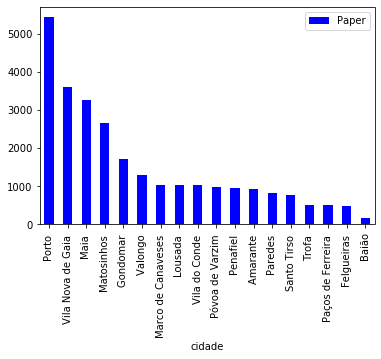

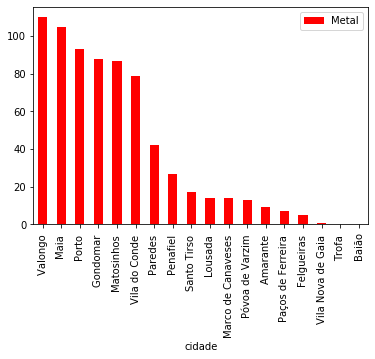

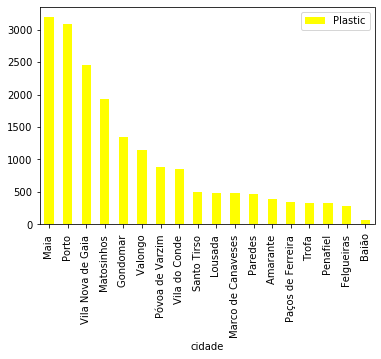

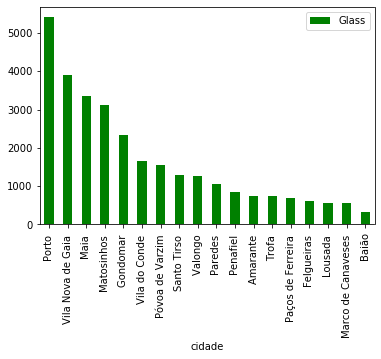

In [7]:
# see waste type amounts compared between cities
coleta_papel = matrix.sort_values(by="papel", ascending = False)
coleta_papel.plot(x ='cidade', y="papel", kind = 'bar', color= 'blue', label ="Paper")
plt.show()

coleta_metal = matrix.sort_values(by="metal", ascending = False)
coleta_metal.plot(x ='cidade', y="metal", kind = 'bar', color= 'red', label ="Metal")
plt.show()

coleta_plastico = matrix.sort_values(by="plástico", ascending = False)
coleta_plastico.plot(x ='cidade', y="plástico", kind = 'bar', color= 'yellow', label ="Plastic")
plt.show()

coleta_vidro = matrix.sort_values(by="vidro", ascending = False)
coleta_vidro.plot(x ='cidade', y="vidro", kind = 'bar', color= 'green', label ="Glass")
plt.show()

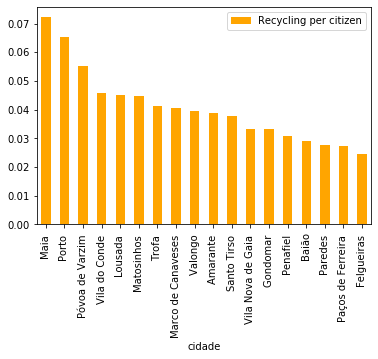

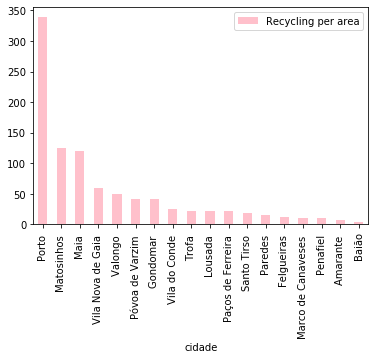

In [8]:
#waste per citizen and waste per area
citizen_waste = waste_per_citizen.sort_values(by="waste per citizen", ascending = False)
citizen_waste.plot(x ='cidade', y='waste per citizen', kind = 'bar', color= 'orange', label ="Recycling per citizen")
plt.show()

area_waste = waste_per_citizen.sort_values(by="waste per area", ascending = False)
area_waste.plot(x ='cidade', y='waste per area', kind = 'bar', color= 'pink', label ="Recycling per area")
plt.show()

In [9]:
#Classifying top 5 cities for each type of waste

top_cities = 5

for hood in matrix['cidade']:
    print("----"+hood+"----")
    temp = matrix[matrix['cidade'] == hood].T.reset_index()
    temp.columns = ['type of waste','amount']
    temp = temp.iloc[1:]
    temp['amount'] = temp['amount'].astype(float)
    temp = temp.round({'amount': 2})
    print(temp.sort_values('amount', ascending=False).reset_index(drop=True).head(top_cities))
    print('\n')

----Porto ----
  type of waste   amount
0   total waste  14022.0
1         papel   5431.0
2         vidro   5406.0
3      plástico   3092.0
4         metal     93.0


----Vila Nova de Gaia ----
  type of waste  amount
0   total waste  9957.0
1         vidro  3891.0
2         papel  3604.0
3      plástico  2461.0
4         metal     1.0


----Maia ----
  type of waste  amount
0   total waste  9903.0
1         vidro  3340.0
2         papel  3269.0
3      plástico  3189.0
4         metal   105.0


----Matosinhos ----
  type of waste  amount
0   total waste  7783.0
1         vidro  3116.0
2         papel  2651.0
3      plástico  1929.0
4         metal    87.0


----Gondomar ----
  type of waste  amount
0   total waste  5480.0
1         vidro  2338.0
2         papel  1707.0
3      plástico  1347.0
4         metal    88.0


----Valongo ----
  type of waste  amount
0   total waste  3796.0
1         papel  1285.0
2         vidro  1256.0
3      plástico  1145.0
4         metal   110.0


----Vil

In [10]:
#Waste/citizen proportion
waste_one = matrix.merge(kpi, how='inner', left_on=['cidade'], right_on=['geodsg'])
waste_one = waste_one[['cidade', 'vidro', 'papel', 'plástico', 'metal', 'total waste', 'População residente']]
waste_one['glass per citizen'] = waste_one['vidro']/waste_one['População residente']
waste_one['paper per citizen'] = waste_one['papel']/waste_one['População residente']
waste_one['plastic per citizen'] = waste_one['plástico']/waste_one['População residente']
waste_one['metal per citizen'] = waste_one['metal']/waste_one['População residente']
waste_one['total per citizen'] = waste_one['total waste']/waste_one['População residente']
waste_one = waste_one[['cidade', 'glass per citizen', 'paper per citizen', 'plastic per citizen', 'metal per citizen', 'total per citizen']]
waste_one.sort_values(by='total per citizen', ascending = False)
waste_one.head()

,cidade,glass per citizen,paper per citizen,plastic per citizen,metal per citizen,total per citizen
0,Porto,0.025152,0.025268,0.014386,0.000433,0.065238
1,Vila Nova de Gaia,0.012975,0.012018,0.008207,0.000003,0.033203
2,Maia,0.024336,0.023818,0.023235,0.000765,0.072154
3,Matosinhos,0.017901,0.015230,0.011082,0.000500,0.044712
4,Gondomar,0.014116,0.010306,0.008133,0.000531,0.033086


In [11]:
weighted_waste = waste_one[['cidade', 'total per citizen']]
weighted_waste.head()

,cidade,total per citizen
0,Porto,0.065238
1,Vila Nova de Gaia,0.033203
2,Maia,0.072154
3,Matosinhos,0.044712
4,Gondomar,0.033086


#### 5. Analyzing relationships

##### A) Relationship between total waste and population age

In [12]:
population_analysis = kpi[['geodsg', 'Jovens (%) <15', 'População em idade activa (%)', 'Idosos (%)']]
population_analysis = weighted_waste.merge(population_analysis, how = 'inner', left_on = 'cidade', right_on ='geodsg')
population_analysis.corr()

,total per citizen,Jovens (%) <15,População em idade activa (%),Idosos (%)
total per citizen,1.000000,0.159421,-0.562734,0.430471
Jovens (%) <15,0.159421,1.000000,0.381354,-0.623723
População em idade activa (%),-0.562734,0.381354,1.000000,-0.960291
Idosos (%),0.430471,-0.623723,-0.960291,1.000000


In [13]:
# Split set for training
msk = np.random.rand(len(weighted_waste)) < 0.75
train = population_analysis[msk]
test = population_analysis[~msk]

In [14]:
from sklearn import linear_model
from sklearn.metrics import r2_score
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['Jovens (%) <15', 'População em idade activa (%)', 'Idosos (%)']])
y = np.asanyarray(train[['total per citizen']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[0.02353069 0.01445231 0.01787066]]


In [15]:
y_hat= regr.predict(test[['Jovens (%) <15', 'População em idade activa (%)', 'Idosos (%)']])
x = np.asanyarray(test[['Jovens (%) <15', 'População em idade activa (%)', 'Idosos (%)']])
y = np.asanyarray(test[['total per citizen']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))
print("R2-score: %.2f" % r2_score(y_hat , y) )

Residual sum of squares: 0.00
Variance score: 0.59
R2-score: 0.47


##### B) Relationship between waste and house pricing

In [16]:
house_analysis = kpi[['geodsg', 'Valores médios de avaliação bancária dos alojamentos (€/m2)','Alojamentos familiares clássicos']]
house_analysis = weighted_waste.merge(house_analysis, how = 'inner', left_on = 'cidade', right_on ='geodsg')
house_analysis.corr()

,total per citizen,Valores médios de avaliação bancária dos alojamentos (€/m2),Alojamentos familiares clássicos
total per citizen,1.000000,0.682526,0.357940
Valores médios de avaliação bancária dos alojamentos (€/m2),0.682526,1.000000,0.764249
Alojamentos familiares clássicos,0.357940,0.764249,1.000000


In [20]:
# Split set for training
msk = np.random.rand(len(weighted_waste)) < 0.75
train = house_analysis[msk]
test = house_analysis[~msk]

In [21]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['Valores médios de avaliação bancária dos alojamentos (€/m2)','Alojamentos familiares clássicos']])
y = np.asanyarray(train[['total per citizen']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ 5.3216357e-05 -1.5580483e-04]]


In [22]:
y_hat= regr.predict(test[['Valores médios de avaliação bancária dos alojamentos (€/m2)','Alojamentos familiares clássicos']])
x = np.asanyarray(test[['Valores médios de avaliação bancária dos alojamentos (€/m2)','Alojamentos familiares clássicos']])
y = np.asanyarray(test[['total per citizen']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))
print("R2-score: %.2f" % r2_score(y_hat , y) )

Residual sum of squares: 0.00
Variance score: -0.08
R2-score: -0.46


##### C) Relationship between waste and students 

In [23]:
students_analysis = kpi[['geodsg', 'Estabelecimentos do ensino préescolar',
       'Estabelecimentos do 1.º ciclo do ensino básico',
       'Estabelecimentos do 2.º ciclo do ensino básico',
       'Estabelecimentos do 3.º ciclo do ensino básico',
       'Estabelecimentos do ensino secundário',
       'Alunos do ensino não superior (5)',
       'Estabelecimentos do ensino superior', 'Alunos do ensino superior (5)']]
students_analysis = weighted_waste.merge(students_analysis, how = 'inner', left_on = 'cidade', right_on ='geodsg')
students_analysis.corr()

,total per citizen,Estabelecimentos do ensino préescolar,Estabelecimentos do 1.º ciclo do ensino básico,Estabelecimentos do 2.º ciclo do ensino básico,Estabelecimentos do 3.º ciclo do ensino básico,Estabelecimentos do ensino secundário,Alunos do ensino não superior (5),Estabelecimentos do ensino superior,Alunos do ensino superior (5)
total per citizen,1.000000,0.364232,0.277486,0.423620,0.377276,0.469376,0.409907,0.475341,0.505609
Estabelecimentos do ensino préescolar,0.364232,1.000000,0.973377,0.882203,0.891396,0.768928,0.965079,0.746970,0.656021
Estabelecimentos do 1.º ciclo do ensino básico,0.277486,0.973377,1.000000,0.812765,0.837416,0.693796,0.907127,0.664314,0.561898
Estabelecimentos do 2.º ciclo do ensino básico,0.423620,0.882203,0.812765,1.000000,0.991486,0.960568,0.966840,0.927230,0.892454
Estabelecimentos do 3.º ciclo do ensino básico,0.377276,0.891396,0.837416,0.991486,1.000000,0.957152,0.966228,0.922340,0.883627
Estabelecimentos do ensino secundário,0.469376,0.768928,0.693796,0.960568,0.957152,1.000000,0.889008,0.984092,0.976484
Alunos do ensino não superior (5),0.409907,0.965079,0.907127,0.966840,0.966228,0.889008,1.000000,0.866236,0.800257
Estabelecimentos do ensino superior,0.475341,0.746970,0.664314,0.927230,0.922340,0.984092,0.866236,1.000000,0.986622
Alunos do ensino superior (5),0.505609,0.656021,0.561898,0.892454,0.883627,0.976484,0.800257,0.986622,1.000000


In [24]:
# Split set for training
msk = np.random.rand(len(weighted_waste)) < 0.75
train = students_analysis[msk]
test = students_analysis[~msk]

In [25]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['Estabelecimentos do ensino préescolar',
       'Estabelecimentos do 1.º ciclo do ensino básico',
       'Estabelecimentos do 2.º ciclo do ensino básico',
       'Estabelecimentos do 3.º ciclo do ensino básico',
       'Estabelecimentos do ensino secundário',
       'Alunos do ensino não superior (5)',
       'Estabelecimentos do ensino superior', 'Alunos do ensino superior (5)']])
y = np.asanyarray(train[['total per citizen']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ 4.80550799e-06  1.20907970e-03  2.96289693e-03 -4.46303167e-03
   9.54614696e-04 -1.38467019e-06 -5.01131737e-03  9.32853185e-06]]


In [26]:
y_hat= regr.predict(test[['Estabelecimentos do ensino préescolar',
       'Estabelecimentos do 1.º ciclo do ensino básico',
       'Estabelecimentos do 2.º ciclo do ensino básico',
       'Estabelecimentos do 3.º ciclo do ensino básico',
       'Estabelecimentos do ensino secundário',
       'Alunos do ensino não superior (5)',
       'Estabelecimentos do ensino superior', 'Alunos do ensino superior (5)']])
x = np.asanyarray(test[['Estabelecimentos do ensino préescolar',
       'Estabelecimentos do 1.º ciclo do ensino básico',
       'Estabelecimentos do 2.º ciclo do ensino básico',
       'Estabelecimentos do 3.º ciclo do ensino básico',
       'Estabelecimentos do ensino secundário',
       'Alunos do ensino não superior (5)',
       'Estabelecimentos do ensino superior', 'Alunos do ensino superior (5)']])
y = np.asanyarray(test[['total per citizen']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))
print("R2-score: %.2f" % r2_score(y_hat , y) )

Residual sum of squares: 0.01
Variance score: -52.49
R2-score: -0.02


##### D) Relationship between waste and spent on sports & culture

In [27]:
sports_analysis = kpi[['geodsg', 'Museus', 'Sessões de espectáculos ao vivo', 'Ecrãs de cinema']]
sports_analysis = weighted_waste.merge(sports_analysis, how = 'inner', left_on = 'cidade', right_on ='geodsg')
sports_analysis.corr()

,total per citizen,Museus,Sessões de espectáculos ao vivo,Ecrãs de cinema
total per citizen,1.000000,0.445524,0.500396,0.176939
Museus,0.445524,1.000000,0.977023,0.415655
Sessões de espectáculos ao vivo,0.500396,0.977023,1.000000,0.309360
Ecrãs de cinema,0.176939,0.415655,0.309360,1.000000


In [28]:
# Split set for training
msk = np.random.rand(len(weighted_waste)) < 0.75
train = sports_analysis[msk]
test = sports_analysis[~msk]

In [29]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['Museus', 'Sessões de espectáculos ao vivo', 'Ecrãs de cinema']])
y = np.asanyarray(train[['total per citizen']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[-2.72570351e-03  2.29301928e-05  3.55084386e-04]]


In [30]:
y_hat= regr.predict(test[['Museus', 'Sessões de espectáculos ao vivo', 'Ecrãs de cinema']])
x = np.asanyarray(test[['Museus', 'Sessões de espectáculos ao vivo', 'Ecrãs de cinema']])
y = np.asanyarray(test[['total per citizen']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))
print("R2-score: %.2f" % r2_score(y_hat , y) )

Residual sum of squares: 0.00
Variance score: -0.08
R2-score: -18.03


##### E) Relationship between waste and wages

In [31]:
wages_analysis = kpi[['geodsg', 'Ganho médio mensal dos trabalhadores por conta de outrem. €','Desempregados inscritos nos centros de emprego']]
wages_analysis = weighted_waste.merge(wages_analysis, how = 'inner', left_on = 'cidade', right_on ='geodsg')
wages_analysis.corr()

,total per citizen,Ganho médio mensal dos trabalhadores por conta de outrem. €,Desempregados inscritos nos centros de emprego
total per citizen,1.000000,0.679653,0.196591
Ganho médio mensal dos trabalhadores por conta de outrem. €,0.679653,1.000000,0.633541
Desempregados inscritos nos centros de emprego,0.196591,0.633541,1.000000


In [32]:
# Split set for training
msk = np.random.rand(len(weighted_waste)) < 0.75
train = wages_analysis[msk]
test = wages_analysis[~msk]

In [33]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['Ganho médio mensal dos trabalhadores por conta de outrem. €','Desempregados inscritos nos centros de emprego']])
y = np.asanyarray(train[['total per citizen']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ 8.15094076e-05 -1.37842123e-06]]


In [34]:
y_hat= regr.predict(test[['Ganho médio mensal dos trabalhadores por conta de outrem. €','Desempregados inscritos nos centros de emprego']])
x = np.asanyarray(test[['Ganho médio mensal dos trabalhadores por conta de outrem. €','Desempregados inscritos nos centros de emprego']])
y = np.asanyarray(test[['total per citizen']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))
print("R2-score: %.2f" % r2_score(y_hat , y) )

Residual sum of squares: 0.00
Variance score: 0.22
R2-score: 0.23


##### F) Relationship between waste and spent on environmental matters

In [35]:
environment_analysis = kpi[['geodsg', 'Despesas do município em ambiente (%)', 'Despesas da Câmara Municipal (7)']]
environment_analysis['Despesas em MA']= environment_analysis['Despesas do município em ambiente (%)'] * environment_analysis['Despesas da Câmara Municipal (7)']
environment_analysis = environment_analysis[['geodsg', 'Despesas em MA', 'Despesas da Câmara Municipal (7)']]
environment_analysis = weighted_waste.merge(environment_analysis, how = 'inner', left_on = 'cidade', right_on ='geodsg')
environment_analysis.corr()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,total per citizen,Despesas em MA,Despesas da Câmara Municipal (7)
total per citizen,1.000000,0.474906,0.498711
Despesas em MA,0.474906,1.000000,0.894564
Despesas da Câmara Municipal (7),0.498711,0.894564,1.000000


In [36]:
# Split set for training
msk = np.random.rand(len(weighted_waste)) < 0.75
train = environment_analysis[msk]
test = environment_analysis[~msk]

In [37]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['Despesas da Câmara Municipal (7)','Despesas em MA']])
y = np.asanyarray(train[['total per citizen']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[1.27859691e-07 4.00187566e-09]]


In [38]:
y_hat= regr.predict(test[['Despesas da Câmara Municipal (7)','Despesas em MA']])
x = np.asanyarray(test[['Despesas da Câmara Municipal (7)','Despesas em MA']])
y = np.asanyarray(test[['total per citizen']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))
print("R2-score: %.2f" % r2_score(y_hat , y) )

Residual sum of squares: 0.00
Variance score: -1.21
R2-score: -2.32


#### 6. Illustrating results on the map

In [39]:
address = 'Porto, Portugal'

geolocator = Nominatim(user_agent="pt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Porto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Porto are 41.1494512, -8.6107884.


In [40]:
#my foursquare data
CLIENT_ID = 'NRVYHZ12WQEQIP4HSL5ATU4NH45OWYF5MGX2B0CIKK4OVJAK' 
CLIENT_SECRET = 'HOA3LBJ33NHG5EK0HYV2V0JGTQMMUBCEN4XG45MTL3NEK5X1' 
VERSION = '20180604'
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [41]:
# create map of cities of Porto District using their latitude and longitude values
map_opo = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for latitude, longitude, cidade in zip(opo['latitude'], opo['longitude'], opo['cidade']):
    label = '{}'.format(cidade)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_opo)  
    
map_opo

#### 6. Presenting results

In [42]:
#Classifying cities
weighted_waste["Recycling City Class"] = "red"
weighted_waste["Recycling City Class"][(weighted_waste["total per citizen"] > 0.025) & (weighted_waste["total per citizen"] < 0.05)] = "yellow"
weighted_waste["Recycling City Class"][(weighted_waste["total per citizen"] > 0.05)] = "green"
weighted_waste = weighted_waste[['cidade', 'total per citizen', 'Recycling City Class']]
final_map = weighted_waste.sort_values(by='total per citizen', ascending = False)
final_map

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

,cidade,total per citizen,Recycling City Class
2,Maia,0.072154,green
0,Porto,0.065238,green
7,Póvoa de Varzim,0.055090,green
6,Vila do Conde,0.045812,yellow
11,Lousada,0.045007,yellow
3,Matosinhos,0.044712,yellow
14,Trofa,0.041241,yellow
12,Marco de Canaveses,0.040702,yellow
5,Valongo,0.039443,yellow
13,Amarante,0.038718,yellow


In [43]:
fim = final_map.merge(opo, how = 'inner', left_on = 'cidade', right_on = 'cidade')
fim = fim[['cidade', 'total per citizen', 'Recycling City Class', 'latitude', 'longitude']]
fim.head()

,cidade,total per citizen,Recycling City Class,latitude,longitude
0,Maia,0.072154,green,41.235739,-8.619897
1,Maia,0.072154,green,41.235739,-8.619897
2,Maia,0.072154,green,41.235739,-8.619897
3,Maia,0.072154,green,41.235739,-8.619897
4,Maia,0.072154,green,41.235739,-8.619897


In [51]:
# create final map
map_final = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for latitude, longitude, cidade, classifier in zip(fim['latitude'], fim['longitude'], fim['cidade'], fim['Recycling City Class']):
    label = '{}', '{}'.format(cidade, classifier)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=classifier,
        fill=True,
        fill_color=classifier,
        fill_opacity=0.7,
        parse_html=False).add_to(map_final)  

In [52]:
map_final